# 09 — Data Visualization for Engineers

Visualization isn't just for analysts — data engineers use it to **debug pipelines**,  
**detect data quality issues**, and **monitor drift** between data batches.

### What you'll learn
| # | Topic | Key Takeaway |
|---|-------|--------------|
| 1 | **Advanced Layouts** | GridSpec & subplots for multi-panel dashboards |
| 2 | **Data Quality Profiling** | Missingness maps, sparsity & cardinality analysis |
| 3 | **Drift Detection** | Compare distributions and correlations across time periods |
| 4 | **Pipeline Diagnostics** | Event density plots and Gantt charts for task monitoring |

In [2]:
# ============================================================
# Setup — load data and configure plotting defaults
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# matplotlib.pyplot  → the main plotting interface (like a drawing canvas)
# matplotlib.gridspec → GridSpec for complex multi-panel layouts

import seaborn as sns
# seaborn → higher-level plotting library built on matplotlib
# Provides statistical plots (KDE, heatmaps, boxplots) with cleaner defaults

from pathlib import Path

# Set a clean visual style
# sns.set_theme() applies seaborn's default theme globally to all plots
# style='whitegrid' adds subtle grid lines on a white background
# palette='muted' uses softer, professional colors
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.0)

# Load the hotel booking dataset
df = pd.read_csv("data/hotel_booking.csv")

# Derive useful columns
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
df["total_revenue"] = df["adr"] * df["total_nights"]

# Parse arrival date
# pd.to_datetime() converts strings to datetime objects
# We build a date string from separate year/month/day columns
df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"] + "-" +
    df["arrival_date_day_of_month"].astype(str),
    format="%Y-%B-%d"
)

print(f"Shape: {df.shape}")
print(f"Date range: {df['arrival_date'].min()} → {df['arrival_date'].max()}")

Shape: (119390, 39)
Date range: 2015-07-01 00:00:00 → 2017-08-31 00:00:00


---
## 1. Advanced Layouts — GridSpec & Subplots

Production dashboards often combine multiple chart types into one figure.  
`GridSpec` gives you pixel-level control over panel sizes and positions.

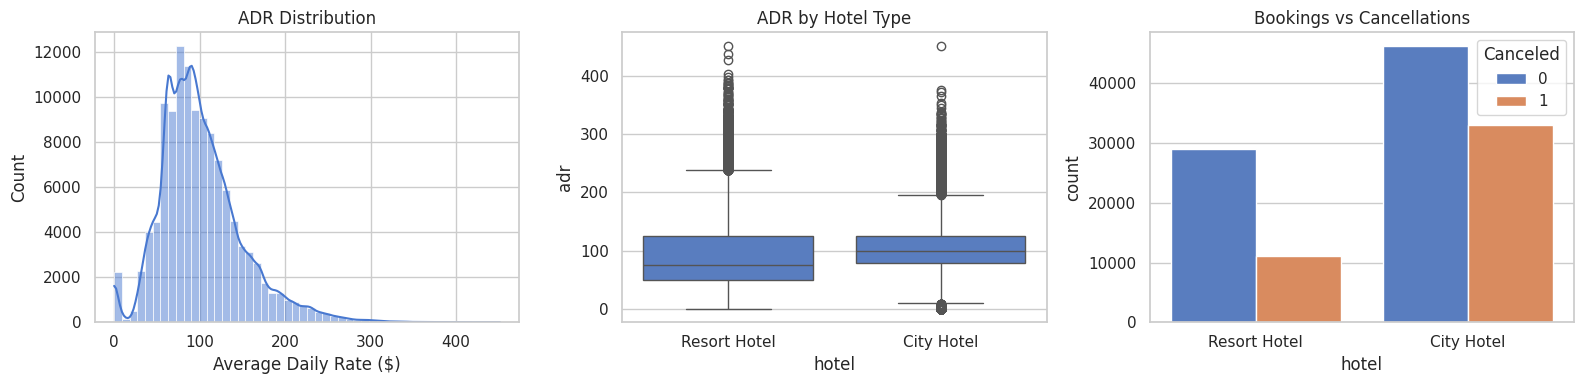

In [2]:
# ============================================================
# 1a. Basic subplots — fig, axes grid
# ============================================================
# plt.subplots(nrows, ncols, figsize) creates a figure with a grid of axes.
#   nrows, ncols → grid dimensions
#   figsize=(width, height) → figure size in inches
#   Returns: fig (the canvas), axes (array of subplot axes)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
# 1 row × 3 columns → three side-by-side panels

# --- Panel 1: Histogram of ADR ---
# axes[0] selects the first subplot
# sns.histplot() draws a histogram (distribution of values)
#   data   : DataFrame
#   x      : column for the x-axis
#   bins   : number of bars
#   kde    : True overlays a smooth density curve (Kernel Density Estimate)
#   ax     : which subplot to draw on
sns.histplot(data=df[df["adr"].between(0, 500)], x="adr", bins=50, kde=True, ax=axes[0])
axes[0].set_title("ADR Distribution")
axes[0].set_xlabel("Average Daily Rate ($)")

# --- Panel 2: Boxplot by hotel type ---
# sns.boxplot() shows median, quartiles, and outliers
#   x : categorical variable (groups)
#   y : numeric variable
sns.boxplot(data=df[df["adr"].between(0, 500)], x="hotel", y="adr", ax=axes[1])
axes[1].set_title("ADR by Hotel Type")

# --- Panel 3: Cancellation count ---
# sns.countplot() counts occurrences of each category
#   hue : color bars by another categorical variable
sns.countplot(data=df, x="hotel", hue="is_canceled", ax=axes[2])
axes[2].set_title("Bookings vs Cancellations")
# get_legend() returns the legend object; set_title() changes its title
axes[2].get_legend().set_title("Canceled")

# fig.tight_layout() adjusts spacing so labels don't overlap
fig.tight_layout()
plt.show()

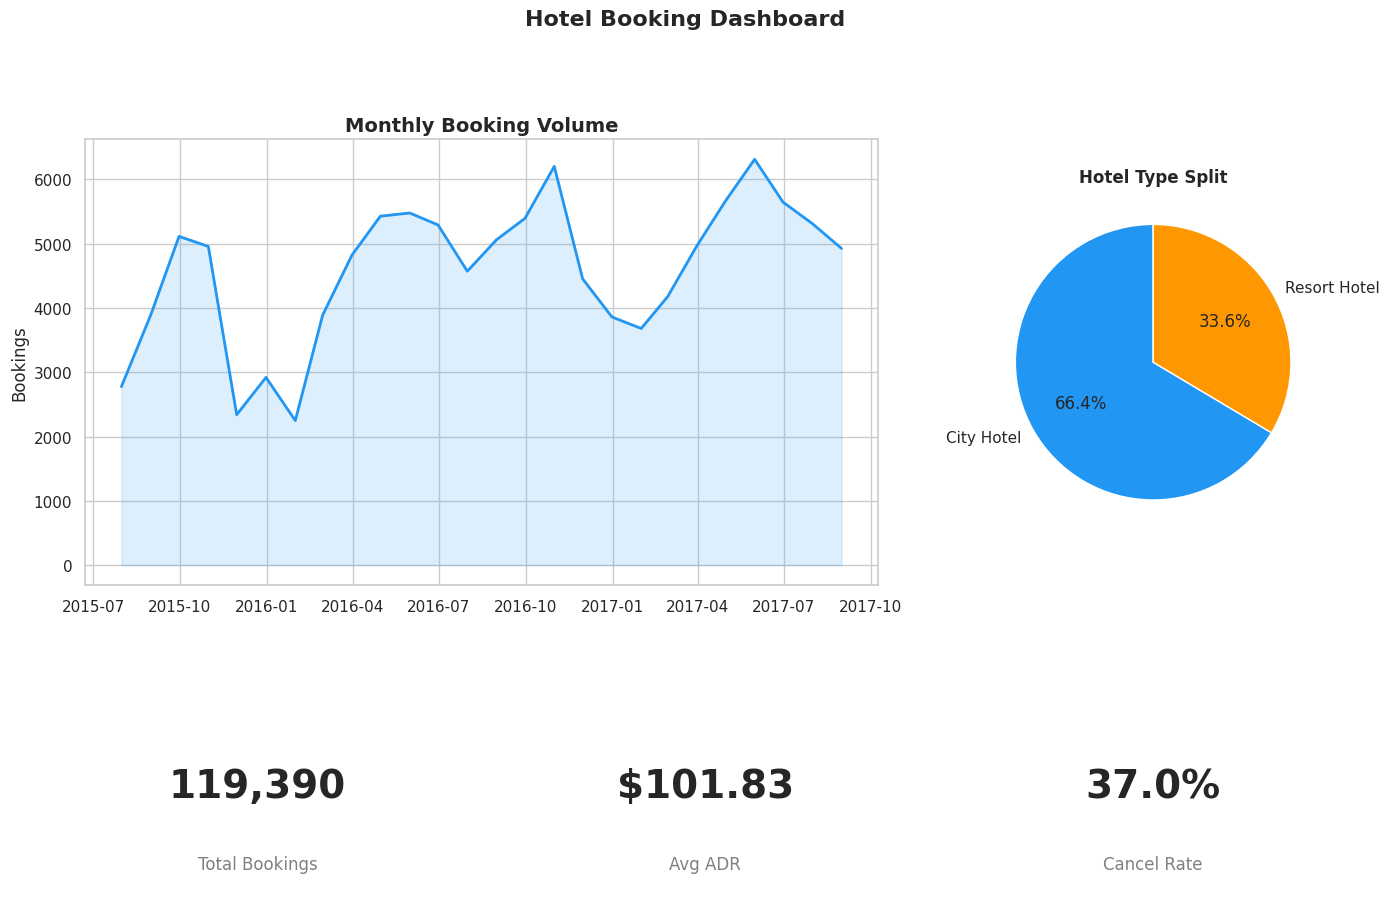

In [3]:
# ============================================================
# 1b. GridSpec — unequal panel sizes for a dashboard
# ============================================================
# GridSpec(nrows, ncols) defines a grid, then you assign axes to regions.
# gs[row, col] selects a cell; gs[0, 0:2] spans columns 0-1.

fig = plt.figure(figsize=(16, 10))
# plt.figure() creates an empty canvas (no subplots yet)

gs = gridspec.GridSpec(
    nrows=2, ncols=3,       # 2 rows × 3 columns grid
    height_ratios=[2, 1],   # top row is 2x taller than bottom
    hspace=0.3,             # vertical spacing between rows
    wspace=0.3,             # horizontal spacing between columns
)

# --- Top-left: wide panel spanning 2 columns ---
# fig.add_subplot(gs[row, cols]) creates an axis in the specified grid region
ax_main = fig.add_subplot(gs[0, 0:2])  # row 0, columns 0-1 (wide)

# Monthly bookings over time
# resample('ME') groups by Month End; .size() counts rows per group
monthly = df.set_index("arrival_date").resample("ME").size()
ax_main.plot(monthly.index, monthly.values, linewidth=2, color="#2196F3")
# ax.fill_between() shades the area under the line
ax_main.fill_between(monthly.index, monthly.values, alpha=0.15, color="#2196F3")
ax_main.set_title("Monthly Booking Volume", fontsize=14, fontweight="bold")
ax_main.set_ylabel("Bookings")

# --- Top-right: small panel ---
ax_pie = fig.add_subplot(gs[0, 2])  # row 0, column 2

# value_counts() counts unique values; .plot.pie() draws a pie chart
hotel_counts = df["hotel"].value_counts()
ax_pie.pie(
    hotel_counts.values,
    labels=hotel_counts.index,
    autopct="%1.1f%%",    # autopct formats the percentage labels
    colors=["#2196F3", "#FF9800"],
    startangle=90,        # rotate so first slice starts at 12 o'clock
)
ax_pie.set_title("Hotel Type Split", fontsize=12, fontweight="bold")

# --- Bottom row: 3 equal KPI panels ---
kpis = [
    ("Total Bookings", f"{len(df):,}"),
    ("Avg ADR", f"${df['adr'].mean():.2f}"),
    ("Cancel Rate", f"{df['is_canceled'].mean() * 100:.1f}%"),
]

for i, (label, value) in enumerate(kpis):
    ax_kpi = fig.add_subplot(gs[1, i])
    ax_kpi.text(0.5, 0.55, value, fontsize=28, fontweight="bold",
                ha="center", va="center", transform=ax_kpi.transAxes)
    # ax.text() places text at (x, y) coordinates
    # ha/va = horizontal/vertical alignment
    # transform=ax.transAxes → coordinates are 0-1 relative to the axis
    ax_kpi.text(0.5, 0.2, label, fontsize=12, color="gray",
                ha="center", va="center", transform=ax_kpi.transAxes)
    ax_kpi.set_xlim(0, 1)
    ax_kpi.set_ylim(0, 1)
    ax_kpi.axis("off")  # hide axes for clean KPI card look

fig.suptitle("Hotel Booking Dashboard", fontsize=16, fontweight="bold", y=1.01)
# fig.suptitle() adds a title above all subplots
plt.show()

---
## 2. Data Quality Profiling

Before trusting data, engineers need to **profile it** — check for nulls,  
unexpected distributions, and cardinality issues.

In [ ]:
# ============================================================
# 2a. Missingness Map — visualize null patterns
# ============================================================
# A missingness heatmap shows WHERE nulls occur across rows and columns.
# Patterns reveal if data is Missing Completely At Random (MCAR)
# or Systematically Missing (e.g., a column is always null for a segment).

# Select columns that might have missing data
cols_to_check = [
    "children", "country", "agent", "company",
    "meal", "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type",
]

# Build a boolean DataFrame: True = missing, False = present
# isnull() returns True where values are NaN/None
missing_matrix = df[cols_to_check].isnull()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Left: Missingness heatmap (sampled rows) ---
# Sample 500 rows for readability (full dataset would be too dense)
sample_idx = np.random.choice(len(missing_matrix), size=500, replace=False)
sample_idx.sort()
# np.random.choice() picks random indices; sort() keeps row order

# sns.heatmap() draws a color-coded matrix
#   cbar=False  → hide the color bar
#   cmap        → color map (binary: white=present, red=missing)
#   yticklabels → hide y-axis labels (too many rows)
sns.heatmap(
    missing_matrix.iloc[sample_idx],  # iloc[] selects rows by integer position
    cbar=False,
    cmap=["#E8F5E9", "#F44336"],  # green=present, red=missing
    yticklabels=False,
    ax=axes[0],
)
axes[0].set_title("Missingness Map (500 sampled rows)", fontweight="bold")
axes[0].set_xlabel("Column")
axes[0].set_ylabel("Row (sampled)")

# --- Right: Missing percentage per column ---
# mean() on booleans = proportion of True (i.e., % missing)
missing_pct = missing_matrix.mean().sort_values(ascending=True) * 100

# barh() draws horizontal bars
colors = ["#F44336" if v > 5 else "#FFC107" if v > 0 else "#4CAF50" for v in missing_pct]
# Color coding: >5% red, >0% yellow, 0% green
axes[1].barh(missing_pct.index, missing_pct.values, color=colors)
axes[1].set_xlabel("Missing %")
axes[1].set_title("Missing Data by Column", fontweight="bold")

# Add percentage labels on bars
for i, v in enumerate(missing_pct.values):
    if v > 0:
        axes[1].text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=9)

fig.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 2b. Systematic vs Random Missingness
# ============================================================
# Check if missingness in one column CORRELATES with another column.
# If 'company' is always null when 'agent' is null → systematic pattern.

# Build a correlation matrix of missingness indicators
# .corr() computes pairwise Pearson correlation between columns
miss_corr = missing_matrix.astype(int).corr()

fig, ax = plt.subplots(figsize=(8, 6))

# sns.heatmap with annotation shows correlation values in each cell
sns.heatmap(
    miss_corr,
    annot=True,         # annot=True prints the value inside each cell
    fmt=".2f",          # format numbers to 2 decimal places
    cmap="RdYlGn_r",    # Red=high correlation (bad), Green=low
    center=0,           # center the color scale at 0
    vmin=-1, vmax=1,    # fix color range to [-1, 1]
    square=True,        # make cells square
    linewidths=0.5,     # thin lines between cells
    ax=ax,
)
ax.set_title("Missingness Correlation\n(high = systematic pattern)", fontweight="bold")
plt.show()

In [ ]:
# ============================================================
# 2c. Sparsity & Cardinality — Long Tail distributions
# ============================================================
# "Cardinality" = number of unique values in a column.
# High-cardinality categoricals often have a "long tail": a few values
# dominate, and many values appear only once or twice.
# This affects joins, groupby performance, and encoding strategies.

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Left: Country cardinality (long tail) ---
country_counts = df["country"].value_counts()

# Plot top 20 + an "Other" bucket
top_n = 20
top = country_counts.head(top_n)
other = pd.Series({"Other": country_counts.iloc[top_n:].sum()})
plot_data = pd.concat([top, other])
# pd.concat() stacks Series together

plot_data.plot.barh(ax=axes[0], color=["#2196F3"] * top_n + ["#BDBDBD"])
# .plot.barh() draws horizontal bars directly from a Series
axes[0].invert_yaxis()  # invert so largest is at the top
axes[0].set_xlabel("Booking Count")
axes[0].set_title(
    f"Country Cardinality: {country_counts.nunique()} unique\n"
    f"(Top {top_n} shown, rest grouped as 'Other')",
    fontweight="bold",
)

# --- Right: Cardinality overview across all categorical columns ---
# select_dtypes('object') selects columns with string/object dtype
cat_cols = df.select_dtypes("object").columns.tolist()

# nunique() returns the number of unique values per column
cardinality = df[cat_cols].nunique().sort_values(ascending=True)

# Color by cardinality level
colors = ["#4CAF50" if v <= 10 else "#FFC107" if v <= 50 else "#F44336" for v in cardinality]
# Green=low (good for encoding), Yellow=medium, Red=high (watch out)

cardinality.plot.barh(ax=axes[1], color=colors)
axes[1].set_xlabel("Unique Values")
axes[1].set_title("Column Cardinality\n(green ≤10, yellow ≤50, red >50)", fontweight="bold")

# Add value labels
for i, v in enumerate(cardinality.values):
    axes[1].text(v + 1, i, str(v), va="center", fontsize=9)

fig.tight_layout()
plt.show()

---
## 3. Drift Detection

**Data drift** = the statistical properties of incoming data change over time.  
Engineers detect this by comparing distributions between time periods  
("yesterday vs today", "training vs production", "source vs target").

In [ ]:
# ============================================================
# 3a. Distribution Comparison — overlaid KDE / Histograms
# ============================================================
# Compare the ADR distribution between two years to detect drift.
# KDE (Kernel Density Estimate) = smooth estimate of the probability distribution.

# Split data by year for comparison
df_2015 = df[(df["arrival_date_year"] == 2015) & (df["adr"].between(0, 500))]
df_2016 = df[(df["arrival_date_year"] == 2016) & (df["adr"].between(0, 500))]
df_2017 = df[(df["arrival_date_year"] == 2017) & (df["adr"].between(0, 500))]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Left: Overlaid KDE plots ---
# sns.kdeplot() draws a smooth density curve
#   fill=True → shade the area under the curve
#   alpha     → transparency (0=invisible, 1=opaque)
#   label     → legend label
sns.kdeplot(data=df_2015, x="adr", fill=True, alpha=0.3, label="2015", ax=axes[0])
sns.kdeplot(data=df_2016, x="adr", fill=True, alpha=0.3, label="2016", ax=axes[0])
sns.kdeplot(data=df_2017, x="adr", fill=True, alpha=0.3, label="2017", ax=axes[0])
axes[0].set_title("ADR Distribution Drift (Year-over-Year)", fontweight="bold")
axes[0].set_xlabel("Average Daily Rate ($)")
axes[0].legend()  # show the legend with year labels

# --- Right: Overlaid histograms (stacked view) ---
# Using matplotlib directly for more control
# ax.hist() draws a histogram
#   bins   : number of bars
#   alpha  : transparency
#   density: True normalizes so area under curve = 1 (comparable across different sample sizes)
axes[1].hist(df_2015["adr"], bins=50, alpha=0.5, density=True, label="2015", color="#2196F3")
axes[1].hist(df_2016["adr"], bins=50, alpha=0.5, density=True, label="2016", color="#FF9800")
axes[1].hist(df_2017["adr"], bins=50, alpha=0.5, density=True, label="2017", color="#4CAF50")
axes[1].set_title("ADR Histogram Comparison (Normalized)", fontweight="bold")
axes[1].set_xlabel("Average Daily Rate ($)")
axes[1].set_ylabel("Density")
axes[1].legend()

fig.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 3b. Multi-metric drift dashboard
# ============================================================
# Compare multiple numeric columns across two periods at once.

drift_cols = ["adr", "lead_time", "total_nights", "total_of_special_requests"]
period_a = df[df["arrival_date_year"] == 2015]  # "baseline"
period_b = df[df["arrival_date_year"] == 2017]  # "current"

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# flatten() converts 2D array of axes → 1D for easy iteration
axes_flat = axes.flatten()

for i, col in enumerate(drift_cols):
    ax = axes_flat[i]

    # Filter out extreme outliers for cleaner plots
    p99 = df[col].quantile(0.99)
    a_clean = period_a[col][period_a[col] <= p99]
    b_clean = period_b[col][period_b[col] <= p99]

    # Draw overlaid KDE
    sns.kdeplot(a_clean, fill=True, alpha=0.3, label="2015 (baseline)", ax=ax, color="#2196F3")
    sns.kdeplot(b_clean, fill=True, alpha=0.3, label="2017 (current)", ax=ax, color="#F44336")

    # Add vertical lines for medians
    # ax.axvline() draws a vertical line at a specified x-value
    ax.axvline(a_clean.median(), color="#2196F3", linestyle="--", linewidth=1.5, label=f"2015 median: {a_clean.median():.1f}")
    ax.axvline(b_clean.median(), color="#F44336", linestyle="--", linewidth=1.5, label=f"2017 median: {b_clean.median():.1f}")

    ax.set_title(f"{col}", fontweight="bold")
    ax.legend(fontsize=8)

fig.suptitle("Distribution Drift: 2015 (Baseline) vs 2017 (Current)", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 3c. Correlation Changes — spot relationship breakdowns
# ============================================================
# If the correlation between two columns CHANGES between periods,
# it signals a data quality issue or upstream schema change.

corr_cols = ["lead_time", "adr", "total_nights", "adults", "children",
             "stays_in_weekend_nights", "stays_in_week_nights",
             "total_of_special_requests", "is_canceled"]

# Compute correlation matrix for each period
# .corr() computes pairwise Pearson correlation (range: -1 to +1)
corr_2015 = period_a[corr_cols].corr()
corr_2017 = period_b[corr_cols].corr()

# Compute the DIFFERENCE: which correlations changed the most?
corr_diff = corr_2017 - corr_2015

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Shared heatmap settings
heatmap_kw = dict(
    annot=True, fmt=".2f", square=True,
    linewidths=0.5, cbar_kws={"shrink": 0.8},
)
# cbar_kws={'shrink': 0.8} makes the color bar 80% of the axis height

sns.heatmap(corr_2015, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            ax=axes[0], **heatmap_kw)
axes[0].set_title("Correlation: 2015\n(Baseline)", fontweight="bold")

sns.heatmap(corr_2017, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            ax=axes[1], **heatmap_kw)
axes[1].set_title("Correlation: 2017\n(Current)", fontweight="bold")

# Difference heatmap — large values indicate drift
sns.heatmap(corr_diff, cmap="PiYG", center=0, vmin=-0.5, vmax=0.5,
            ax=axes[2], **heatmap_kw)
axes[2].set_title("Correlation CHANGE\n(2017 − 2015)", fontweight="bold")

fig.tight_layout()
plt.show()

---
## 4. Pipeline Diagnostics

Engineers need to visualize **pipeline health**: Are we ingesting the expected  
number of rows? Are tasks running on time? Where are the bottlenecks?

In [ ]:
# ============================================================
# 4a. Event Density — row counts over time
# ============================================================
# Plot the number of bookings arriving each day.
# Gaps or spikes indicate ingestion problems.

# Group by arrival date and count rows
daily_counts = df.groupby("arrival_date").size()
# .size() counts rows per group (including NaN, unlike .count())

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
# sharex=True makes both subplots share the same x-axis

# --- Top: Daily event count ---
axes[0].plot(daily_counts.index, daily_counts.values, linewidth=0.8, alpha=0.7, color="#2196F3")

# Add a rolling average to smooth out noise
# rolling(window=7) computes a 7-day moving window
# .mean() takes the average within each window
rolling_avg = daily_counts.rolling(window=7).mean()
axes[0].plot(rolling_avg.index, rolling_avg.values, linewidth=2, color="#F44336", label="7-day rolling avg")
axes[0].set_ylabel("Bookings / Day")
axes[0].set_title("Daily Booking Ingestion Volume", fontweight="bold")
axes[0].legend()

# Highlight anomalies: days with count > 2 standard deviations from mean
mean_count = daily_counts.mean()
std_count = daily_counts.std()
upper_bound = mean_count + 2 * std_count
lower_bound = mean_count - 2 * std_count

# axhspan() draws a horizontal band (normal range)
axes[0].axhspan(lower_bound, upper_bound, alpha=0.1, color="green", label="±2σ normal range")

# Mark anomaly days with red dots
anomalies = daily_counts[(daily_counts > upper_bound) | (daily_counts < lower_bound)]
axes[0].scatter(anomalies.index, anomalies.values, color="red", s=20, zorder=5, label=f"Anomalies ({len(anomalies)} days)")
# scatter() draws individual points; zorder=5 ensures they draw on top
axes[0].legend(fontsize=9)

# --- Bottom: Cumulative ingestion ---
# cumsum() computes the running total
cumulative = daily_counts.cumsum()
axes[1].fill_between(cumulative.index, cumulative.values, alpha=0.3, color="#2196F3")
axes[1].plot(cumulative.index, cumulative.values, linewidth=1.5, color="#2196F3")
axes[1].set_ylabel("Cumulative Bookings")
axes[1].set_xlabel("Date")
axes[1].set_title("Cumulative Ingestion (stalled = gap)", fontweight="bold")

fig.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 4b. Ingestion gap detection
# ============================================================
# Find dates where no data arrived (missing dates in time series).

# pd.date_range() creates a complete sequence of dates (no gaps)
full_range = pd.date_range(
    start=daily_counts.index.min(),
    end=daily_counts.index.max(),
    freq="D",  # daily frequency
)

# reindex() aligns the series to the full date range; missing dates become NaN
complete = daily_counts.reindex(full_range)

# Find gap dates (NaN = no data for that day)
gaps = complete[complete.isna()]
print(f"Total expected days: {len(full_range)}")
print(f"Days with data    : {daily_counts.count()}")
print(f"Missing days (gaps): {len(gaps)}")

if len(gaps) > 0:
    print(f"\nGap dates:")
    for d in gaps.index[:20]:  # show first 20
        print(f"  {d.strftime('%Y-%m-%d')} ({d.strftime('%A')})")
else:
    print("No gaps detected — complete daily coverage.")

In [ ]:
# ============================================================
# 4c. Gantt Chart — visualize pipeline task execution
# ============================================================
# Gantt charts show when tasks START and END, revealing:
# - Which tasks run in parallel vs. sequentially
# - Bottleneck tasks (longest bars)
# - Task dependencies and scheduling gaps

from datetime import datetime, timedelta

# Simulated pipeline schedule (start_time, duration_minutes)
pipeline_tasks = [
    {"task": "Extract: hotel_booking.csv",  "start": 0,  "duration": 12, "status": "success"},
    {"task": "Extract: country_dim.csv",    "start": 0,  "duration": 3,  "status": "success"},
    {"task": "Validate: null checks",       "start": 12, "duration": 5,  "status": "success"},
    {"task": "Validate: schema check",      "start": 12, "duration": 4,  "status": "success"},
    {"task": "Transform: clean & enrich",   "start": 17, "duration": 20, "status": "success"},
    {"task": "Transform: aggregate",        "start": 37, "duration": 8,  "status": "success"},
    {"task": "Load: write to Parquet",      "start": 45, "duration": 6,  "status": "success"},
    {"task": "Load: write to DuckDB",       "start": 45, "duration": 10, "status": "warning"},
    {"task": "Test: row count check",       "start": 55, "duration": 2,  "status": "success"},
    {"task": "Test: data quality report",   "start": 55, "duration": 5,  "status": "failed"},
]

# Color map for task status
status_colors = {
    "success": "#4CAF50",  # green
    "warning": "#FFC107",  # yellow
    "failed":  "#F44336",  # red
}

fig, ax = plt.subplots(figsize=(14, 6))

# ax.barh() draws horizontal bars — perfect for Gantt charts
#   y     : vertical position (task index)
#   width : bar width (duration)
#   left  : bar start position (start time)
#   height: bar thickness
for i, task in enumerate(reversed(pipeline_tasks)):
    ax.barh(
        y=i,                            # vertical position
        width=task["duration"],          # bar length = duration
        left=task["start"],              # bar starts at this x position
        height=0.6,                      # bar thickness
        color=status_colors[task["status"]],
        edgecolor="white",               # white border between bars
        linewidth=0.5,
    )
    # Add duration label inside the bar
    ax.text(
        task["start"] + task["duration"] / 2,  # center of bar
        i,
        f"{task['duration']}m",
        ha="center", va="center", fontsize=9, fontweight="bold", color="white",
    )

# Set task names as y-axis labels
ax.set_yticks(range(len(pipeline_tasks)))
# set_yticks() defines which positions get labels
ax.set_yticklabels([t["task"] for t in reversed(pipeline_tasks)])
# set_yticklabels() sets the label text for each tick

ax.set_xlabel("Time (minutes since pipeline start)")
ax.set_title("Pipeline Execution — Gantt Chart", fontsize=14, fontweight="bold")

# Add a legend for status colors
from matplotlib.patches import Patch
# Patch creates a colored rectangle for legend entries
legend_handles = [Patch(facecolor=c, label=s) for s, c in status_colors.items()]
ax.legend(handles=legend_handles, loc="lower right")

# Add gridlines for readability
ax.set_axisbelow(True)  # grid lines behind the bars
ax.xaxis.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 4d. Pipeline Timing Breakdown — stacked bar chart
# ============================================================
# Aggregate task durations by phase (Extract, Transform, Load, Test)
# to see where the pipeline spends most of its time.

# Group tasks by phase (first word of task name)
phase_durations = {}
for task in pipeline_tasks:
    phase = task["task"].split(":")[0].strip()  # e.g., "Extract", "Transform"
    phase_durations[phase] = phase_durations.get(phase, 0) + task["duration"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Bar chart of phase durations ---
phases = list(phase_durations.keys())
durations = list(phase_durations.values())
colors = ["#2196F3", "#FF9800", "#4CAF50", "#9C27B0"]

bars = axes[0].bar(phases, durations, color=colors[:len(phases)])
# ax.bar() draws vertical bars
axes[0].set_ylabel("Total Duration (minutes)")
axes[0].set_title("Time Spent per Pipeline Phase", fontweight="bold")

# ax.bar_label() adds value labels on top of each bar
axes[0].bar_label(bars, fmt="%d min", fontweight="bold")

# --- Right: Pie chart of time distribution ---
axes[1].pie(
    durations,
    labels=phases,
    autopct="%1.0f%%",
    colors=colors[:len(phases)],
    startangle=90,
    # explode moves a slice outward (highlight the biggest phase)
    explode=[0.05 if d == max(durations) else 0 for d in durations],
)
axes[1].set_title("Pipeline Time Distribution", fontweight="bold")

fig.tight_layout()
plt.show()

---
## Key Takeaways

| Technique | Matplotlib/Seaborn | DE Use Case |
|-----------|-------------------|-------------|
| **GridSpec** | `gridspec.GridSpec()`, `fig.add_subplot(gs[...])` | Build multi-panel dashboards with unequal panel sizes |
| **Missingness Map** | `sns.heatmap(df.isnull())` | Spot systematic vs. random null patterns |
| **Cardinality** | `value_counts()`, `nunique()`, `barh()` | Detect long-tail distributions, high-cardinality columns |
| **KDE Overlay** | `sns.kdeplot(fill=True)` | Compare distributions across time periods (drift) |
| **Correlation Diff** | `corr_a - corr_b`, heatmap | Detect relationship changes between data batches |
| **Event Density** | `groupby().size()`, `rolling().mean()` | Monitor ingestion volume, detect gaps and spikes |
| **Gantt Chart** | `ax.barh(left=start, width=duration)` | Visualize task scheduling, bottlenecks, failures |

---

## Next Steps

You've completed the full Python for Data Engineering learning path:  
1. **File Handling** — Pathlib, CSV, JSON, JSONL, generators, binary I/O  
2. **Standard Libraries** — datetime, os/sys, logging, collections, glob  
3. **Numpy, Pandas & Parquet** — Vectorized processing, transformations, columnar storage  
4. **DuckDB SQL Analytics** — In-process OLAP, file querying, window functions  
5. **Visualization for Engineers** — Data quality profiling, drift detection, pipeline monitoring